C:\Users\Harmon\AppData\Local\Temp\ipykernel_37772\1004789247.py:16: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Error reading file: 'utf-8' codec can't decode byte 0xbc in position 12: invalid start byte
========== DATA OVERVIEW ==========
Shape: (7728394, 50)
Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Year', 'Month', 'Hour', 'Weekday']

Preview of dataset:
    ID   Source  Severity          Start_Time             End_Time  Start_Lat  \
0  A-1  Source2         3 2016-02-08 05:46:00  2016-02

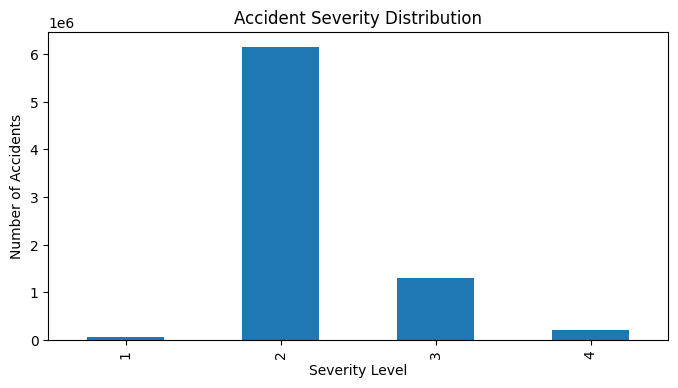

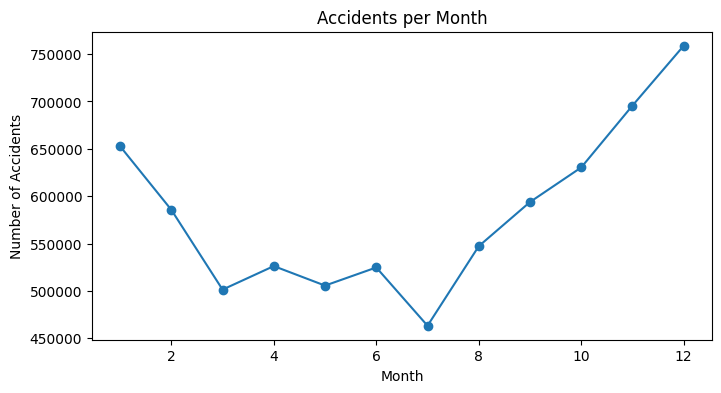

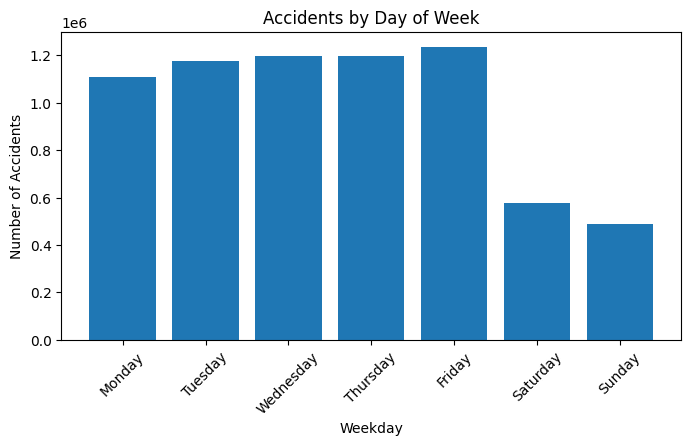

========== HYPOTHESIS TEST ==========
T-test: Severity in CA vs TX
Statistic = -86.0865, p-value = 0.0000e+00

========== CORRELATION MATRIX ==========


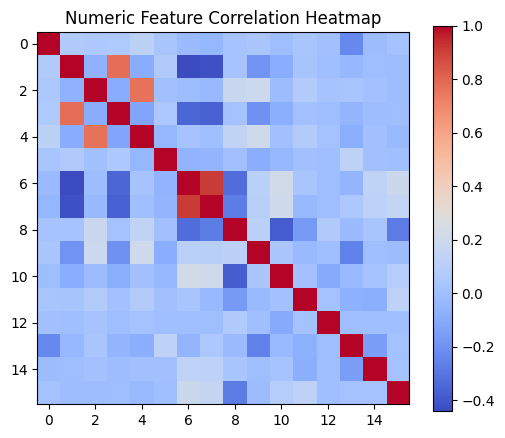

========== OUTLIER ANALYSIS ==========
Estimated number of outlier values: 888,451


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.float_format', '{:.2f}'.format)

try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
except ImportError:
    print("kagglehub not found. Run pip install kagglehub in your terminal")

try:
    file_path = "US_Accidents_March23.csv"
    print("Downloading dataset from Kaggle...")
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "sobhanmoosavi/us-accidents",
        file_path
    )
    print("Dataset loaded from Kaggle.")
except Exception as e:
    print(e)
    
    

print("========== DATA OVERVIEW ==========")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nPreview of dataset:")
print(df.head(), "\n")

df = df.dropna(axis=1, thresh=len(df)*0.5)
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.day_name()

print("========== SUMMARY STATISTICS ==========")
print(df.describe(), "\n")

plt.figure(figsize=(8,4))
df['Severity'].value_counts().sort_index().plot(kind='bar')
plt.title('Accident Severity Distribution')
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.show()

monthly_counts = df.groupby('Month')['ID'].count()
plt.figure(figsize=(8,4))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title('Accidents per Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.show()

week_counts = (
    df.groupby('Weekday')['ID']
    .count()
    .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
)
plt.figure(figsize=(8,4))
plt.bar(week_counts.index, week_counts.values)
plt.title('Accidents by Day of Week')
plt.xlabel('Weekday')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

print("========== HYPOTHESIS TEST ==========")
subset = df.query("State == 'CA'")
other = df.query("State == 'TX'")
t_stat, p_val = stats.ttest_ind(
    subset['Severity'], other['Severity'],
    equal_var=False, nan_policy='omit'
)
print(f"T-test: Severity in CA vs TX\nStatistic = {t_stat:.4f}, p-value = {p_val:.4e}\n")

print("========== CORRELATION MATRIX ==========")
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Numeric Feature Correlation Heatmap')
plt.show()

z_scores = np.abs(stats.zscore(df[numeric_cols].dropna()))
outliers = (z_scores > 3).sum().sum()
print("========== OUTLIER ANALYSIS ==========")
print(f"Estimated number of outlier values: {outliers:,}")
print("=======================================")

In [6]:
print("~~~ BASIC STRUCTURE ~~~")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\n")

print("~~~ MISSING VALUES ~~~")
print(df.isnull().sum().sort_values(ascending=False).head(20))
print("\n")

print("~~~ UNIQUE VALUE COUNTS (top 20 columns with fewest unique values) ~~~")
print(df.nunique().sort_values().head(20))
print("\n")

print("~~~ TOP STATES BY ACCIDENT COUNT ~~~")
print(df['State'].value_counts().head(10))
print("\n")

print("~~~ TOP WEATHER CONDITIONS ~~~")
print(df['Weather_Condition'].value_counts().head(10))
print("\n")

print("~~~ SEVERITY DISTRIBUTION ~~~")
print(df['Severity'].value_counts(normalize=True).sort_index() * 100)
print("\n")

print("~~~ CORRELATION WITH SEVERITY (NUMERIC FEATURES) ~~~")
corrs = df.select_dtypes(include=np.number).corr()['Severity'].sort_values(ascending=False)
print(corrs.head(10))
print(corrs.tail(10))
print("\n")

print("~~~ TIME ANALYSIS ~~~")
print("Accidents per Year:\n", df['Year'].value_counts().sort_index())
print("\nAccidents per Month:\n", df['Month'].value_counts().sort_index())
print("\nAccidents per Weekday:\n", df['Weekday'].value_counts())
print("\n")

print("~~~ EXTREME VALUES ~~~")
print("Max Temperature:", df['Temperature(F)'].max())
print("Min Temperature:", df['Temperature(F)'].min())
print("Max Wind Speed:", df['Wind_Speed(mph)'].max())
print("Max Distance:", df['Distance(mi)'].max())
print("Mean Distance:", df['Distance(mi)'].mean())
print("\n")

print("~~~ NUMERIC SUMMARY ~~~")
print(df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(2))


~~~ BASIC STRUCTURE ~~~
Shape: (7728394, 50)
Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Year', 'Month', 'Hour', 'Weekday']


~~~ MISSING VALUES ~~~
Start_Time               743166
Weekday                  743166
Year                     743166
Month                    743166
Hour                     743166
Wind_Direction           175206
Weather_Condition        173459
Weather_Tim

~~~ BASIC STRUCTURE ~~~
Shape: (7728394, 50)
Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Year', 'Month', 'Hour', 'Weekday']


~~~ MISSING VALUES ~~~
Start_Time               743166
Weekday                  743166
Year                     743166
Month                    743166
Hour                     743166
Wind_Direction           175206
Weather_Condition        173459
Weather_Timestamp        120228
Sunrise_Sunset            23246
Astronomical_Twilight     23246
Nautical_Twilight         23246
Civil_Twilight            23246
Airport_Code              22635
Street                    10869
Timezone                   7808
Zipcode                    1915
City                        253
Description                   5
Country                       0
State                         0
dtype: int64


~~~ UNIQUE VALUE COUNTS (top 20 columns with fewest unique values) ~~~
Country                  1
Turning_Loop             1
Amenity                  2
Bump                     2
Civil_Twilight           2
Sunrise_Sunset           2
Traffic_Signal           2
Crossing                 2
Railway                  2
Stop                     2
Station                  2
Roundabout               2
Junction                 2
No_Exit                  2
Give_Way                 2
Traffic_Calming          2
Astronomical_Twilight    2
Nautical_Twilight        2
Source                   3
Severity                 4
dtype: int64


~~~ TOP STATES BY ACCIDENT COUNT ~~~
State
CA    1741433
FL     880192
TX     582837
SC     382557
NY     347960
NC     338199
VA     303301
PA     296620
MN     192084
OR     179660
Name: count, dtype: int64


~~~ TOP WEATHER CONDITIONS ~~~
Weather_Condition
Fair                2560802
Mostly Cloudy       1016195
Cloudy               817082
Clear                808743
Partly Cloudy        698972
Overcast             382866
Light Rain           352957
Scattered Clouds     204829
Light Snow           128680
Fog                   99238
Name: count, dtype: int64


~~~ SEVERITY DISTRIBUTION ~~~
Severity
1     0.871669
2    79.667017
3    16.812510
4     2.648804
Name: proportion, dtype: float64


~~~ CORRELATION WITH SEVERITY (NUMERIC FEATURES) ~~~
Severity           1.000000
End_Lng            0.121178
Start_Lat          0.069060
End_Lat            0.056135
Start_Lng          0.052862
Pressure(in)       0.042152
Wind_Speed(mph)    0.035751
Distance(mi)       0.034787
Humidity(%)        0.022079
Hour               0.018479
Name: Severity, dtype: float64
Wind_Speed(mph)      0.035751
Distance(mi)         0.034787
Humidity(%)          0.022079
Hour                 0.018479
Precipitation(in)    0.009159
Visibility(mi)      -0.002804
Month               -0.015949
Temperature(F)      -0.019966
Wind_Chill(F)       -0.041381
Year                -0.232329
Name: Severity, dtype: float64


~~~ TIME ANALYSIS ~~~
Accidents per Year:
 Year
2016.0     410821
2017.0     717290
2018.0     893426
2019.0     954302
2020.0    1161598
2021.0    1412433
2022.0    1268806
2023.0     166552
Name: count, dtype: int64

Accidents per Month:
 Month
1.0     652682
2.0     585606
3.0     501362
4.0     526210
5.0     505614
6.0     524750
7.0     463263
8.0     547206
9.0     593815
10.0    630325
11.0    695612
12.0    758783
Name: count, dtype: int64

Accidents per Weekday:
 Weekday
Friday       1237229
Thursday     1196137
Wednesday    1195864
Tuesday      1177923
Monday       1108807
Saturday      579153
Sunday        490115
Name: count, dtype: int64


~~~ EXTREME VALUES ~~~
Max Temperature: 207.0
Min Temperature: -89.0
Max Wind Speed: 1087.0
Max Distance: 441.75
Mean Distance: 0.5618422831523753


~~~ NUMERIC SUMMARY ~~~
                                            mean        std  \
Severity                                2.212384   0.487531   
Start_Time         2020-03-21 21:49:59.056443136        NaN   
Start_Lat                              36.201195   5.076079   
Start_Lng                             -94.702545  17.391756   
End_Lat                                36.227339   3.945038   
End_Lng                               -92.336331  14.075809   
Distance(mi)                            0.561842   1.776811   
Temperature(F)                         61.712827  18.814027   
Wind_Chill(F)                          59.220749  19.347678   
Humidity(%)                            64.879915  22.564686   
Pressure(in)                           29.544829   0.997913   
Visibility(mi)                          9.111221   2.660819   
Wind_Speed(mph)                         7.634823   5.223725   
Precipitation(in)                        0.00601   0.093272   
Year                                 2019.701283   1.888793   
Month                                   6.747753   3.623057   
Hour                                   12.267794   5.455518   

                                   min                            25%  \
Severity                           1.0                            2.0   
Start_Time         2016-01-14 20:18:33  2018-09-17 02:20:31.750000128   
Start_Lat                      24.5548                      33.399631   
Start_Lng                  -124.623833                    -117.219396   
End_Lat                      24.566013                      35.186481   
End_Lng                    -124.545748                     -93.323463   
Distance(mi)                       0.0                            0.0   
Temperature(F)                   -89.0                           50.0   
Wind_Chill(F)                    -89.0                           52.0   
Humidity(%)                        1.0                           49.0   
Pressure(in)                       0.0                          29.38   
Visibility(mi)                     0.0                           10.0   
Wind_Speed(mph)                    0.0                            5.0   
Precipitation(in)                  0.0                            0.0   
Year                            2016.0                         2018.0   
Month                              1.0                            4.0   
Hour                               0.0                            8.0   

                                          50%                  75%  \
Severity                                  2.0                  2.0   
Start_Time         2020-06-23 13:37:23.500000  2021-10-28 15:44:07   
Start_Lat                           35.823974            40.084959   
Start_Lng                          -87.766616           -80.353676   
End_Lat                             36.183495            37.517262   
End_Lng                             -88.02789           -84.990476   
Distance(mi)                             0.03                0.464   
Temperature(F)                           64.0                 76.0   
Wind_Chill(F)                            62.0                 71.0   
Humidity(%)                              67.0                 84.0   
Pressure(in)                            29.86                30.03   
Visibility(mi)                           10.0                 10.0   
Wind_Speed(mph)                           7.0                 10.0   
Precipitation(in)                         0.0                  0.0   
Year                                   2020.0               2021.0   
Month                                     7.0                 10.0   
Hour                                     13.0                 17.0   

                                   max  
Severity                           4.0  
Start_Time         2023-03-31 23:30:00  
Start_Lat                    49.002201  
Start_Lng                   -67.113167  
End_Lat                         49.075  
End_Lng                     -67.109242  
Distance(mi)                    441.75  
Temperature(F)                   207.0  
Wind_Chill(F)                    207.0  
Humidity(%)                      100.0  
Pressure(in)                     58.63  
Visibility(mi)                   140.0  
Wind_Speed(mph)                 1087.0  
Precipitation(in)                36.47  
Year                            2023.0  
Month                             12.0  
Hour                              23.0  